In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


In [18]:
# Step 1: Fetch S&P 500 data
def get_sp500_tickers():
    # Get S&P 500 tickers from Wikipedia
    sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(sp500_url, header=0)
    tickers = table[0]['Symbol'].tolist()
    return tickers

# Fetch S&P 500 tickers
tickers = get_sp500_tickers()
tickers = [ticker.replace('.', '-') for ticker in tickers]  # Adjust for yfinance

# Download historical data for the last year
data = yf.download(tickers, start="2014-01-01", end="2024-01-01")['Adj Close']

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'AMTM', 'SOLV', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1388552400, endDate = 1704085200")')


In [19]:
data.to_csv("sp500_data.csv", index=True)

In [11]:
# Step 2: Preprocessing - Remove Excessive Missing Values
data_rem = data.dropna(thresh=int(0.8 * len(data.columns)), axis=0)  # At least 80% valid rows
data_rem = data_rem.dropna(thresh=int(0.8 * len(data)), axis=1)  # At least 80% valid columns


Mean Squared Error (MSE) between actual and reconstructed prices: nan
Correlation coefficients between actual and reconstructed prices:
Ticker
A      NaN
AAPL   NaN
ABBV   NaN
ABT    NaN
ACGL   NaN
        ..
XYL    NaN
YUM    NaN
ZBH    NaN
ZBRA   NaN
ZTS    NaN
Length: 474, dtype: float64


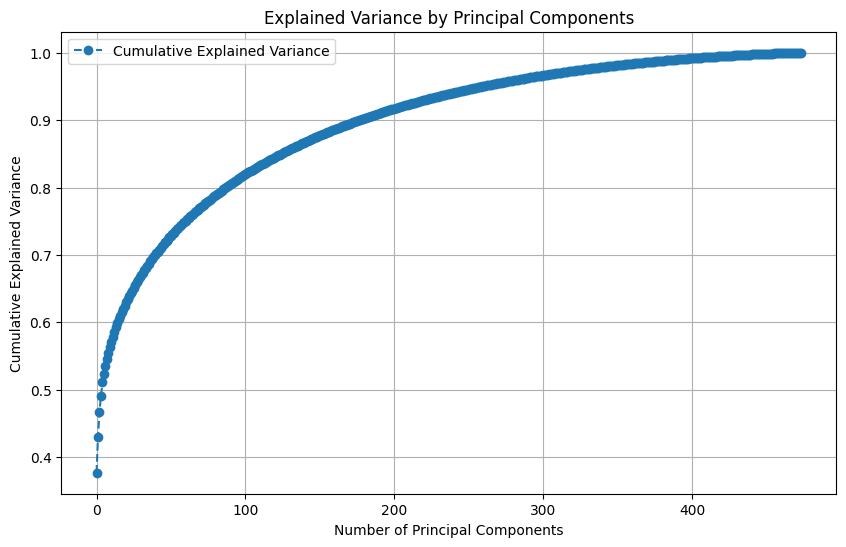

Top 10 stocks by weight in the dominant principal component:
    Stock    Weight
118   CZR  0.095723
309  NCLH  0.091741
79    CCL  0.088499
35    APA  0.083789
369   RCL  0.083434
421  TRGP  0.078891
333    ON  0.078770
287   MGM  0.078499
172   FCX  0.076727
139   DVN  0.075709


In [14]:

# %%
# Step 2: Remove stocks with excessive missing values
# At least 80% valid data for rows and columns
data_rem = data.dropna(thresh=int(0.8 * len(data.columns)), axis=0)  
data_rem = data_rem.dropna(thresh=int(0.8 * len(data)), axis=1)

# %%
# Step 3: Calculate daily log returns
log_returns = np.log(data_rem / data_rem.shift(1)).dropna()

# %%
# Step 5: Compute covariance matrix
cov_matrix = log_returns.cov()

# Step 6: Perform spectral decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Explained variance ratio
explained_variance_ratio = eigenvalues / eigenvalues.sum()

# %%
# Step 7: Reconstruct stock price movements
# Choose the top k principal components
num_components = len(eigenvalues)  # Adjust to desired number of components, for now selecting all
principal_components = eigenvectors[:, :num_components]

# Reconstruct log returns using the top principal components
reconstructed_returns = centered_log_returns.dot(principal_components).dot(principal_components.T)


# Convert log returns to cumulative prices
reconstructed_prices = np.exp(reconstructed_returns.cumsum()) * data_rem.iloc[0]

# %%
# Ensure reconstructed prices align with the original data
reconstructed_prices = pd.DataFrame(reconstructed_prices, index=log_returns.index, columns=log_returns.columns)

# Compute log prices for both original and reconstructed data
original_log_prices = np.log(data_rem)
reconstructed_log_prices = np.log(reconstructed_prices)

# Align reconstructed prices with original prices to ensure consistent dimensions
aligned_original_log_prices = original_log_prices.loc[reconstructed_log_prices.index]

# Mean Squared Error
mse = ((aligned_original_log_prices - reconstructed_log_prices) ** 2).mean().mean()

# Correlation coefficients (per stock)
correlation_coefficients = np.diag(
    np.corrcoef(aligned_original_log_prices.T, reconstructed_log_prices.T)[:len(aligned_original_log_prices.columns),
                                                                             len(aligned_original_log_prices.columns):]
)

# Output results
print(f"Mean Squared Error (MSE) between actual and reconstructed prices: {mse}")
print("Correlation coefficients between actual and reconstructed prices:")
print(pd.Series(correlation_coefficients, index=data_rem.columns).sort_values(ascending=False))


# %%
# Step 9: Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# %%
# Step 10: Analyze the dominant principal component
dominant_pc = eigenvectors[:, 0]

# Ensure positive orientation of the dominant PC
if dominant_pc[0] < 0:
    dominant_pc *= -1

# Create a DataFrame for stock weights in the dominant principal component
stock_weights = pd.DataFrame({
    'Stock': centered_log_returns.columns,
    'Weight': dominant_pc
}).sort_values(by='Weight', ascending=False)

# Output top 10 stocks by weight
print("Top 10 stocks by weight in the dominant principal component:")
print(stock_weights.head(10))